# Extended Kalman Filter (EKF) Demo

Demonstrates EKF with non-linear Range-Bearing tracking:
- Linear motion (constant velocity)
- Non-linear observations (range/bearing in polar coordinates)
- User-provided Jacobian functions

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from ekf import ExtendedKalmanFilter
from range_bearing_model import RangeBearingModel

tf.random.set_seed(42)
np.random.seed(42)

## 1. Generate Data

In [21]:
# Create model and generate trajectory
dt = 1.0
model = RangeBearingModel(
    dt=dt, 
    process_noise_std_pos=0.1, 
    process_noise_std_vel=0.1,
    range_noise_std=50.0, 
    bearing_noise_std=0.005, 
    seed=42
)

T = 100
true_states, obs = model.simulate_trajectory(T=T)

print(f"Generated {T} observations")
print(f"True states: {true_states.shape}, Observations: {obs.shape}")

Generated 100 observations
True states: (4, 101), Observations: (2, 100)


## 2. Define Functions and Jacobians

In [22]:
# State transition: x_t = A @ x_{t-1}
def state_transition_fn(x, u=None):
    return tf.matmul(model.A, x)

# Observation: z = [range, bearing]
def observation_fn(x):
    x_pos, y_pos = x[0, 0], x[2, 0]
    r = tf.sqrt(x_pos**2 + y_pos**2)
    theta = tf.atan2(y_pos, x_pos)
    return tf.stack([r, theta])[:, tf.newaxis]

# Jacobians (using model's methods)
state_transition_jacobian_fn = lambda x, u=None: model.A
observation_jacobian_fn = model.compute_observation_jacobian

print("Functions and Jacobians defined")

Functions and Jacobians defined


## 3. Initialize and Run EKF

In [23]:
# Initialize EKF
x0 = true_states[:,1]
Sigma0 = tf.eye(4, dtype=tf.float32) * 100.0

ekf = ExtendedKalmanFilter(
    state_transition_fn=state_transition_fn,
    observation_fn=observation_fn,
    Q=model.Q, 
    R=model.R, 
    x0=x0, 
    Sigma0=Sigma0,
    state_transition_jacobian_fn=state_transition_jacobian_fn,
    observation_jacobian_fn=observation_jacobian_fn
)

In [24]:
# Run filter
filtered_states, predicted_states = ekf.filter(obs)
print(f"Filtered states: {filtered_states.shape}")

Filtered states: (4, 101)


## 4. Evaluate Performance

In [25]:
# Position RMSE
pos_error_filtered = tf.sqrt(
    (filtered_states[0, 1:] - true_states[0, 1:])**2 +
    (filtered_states[2, 1:] - true_states[2, 1:])**2
)
pos_error_predicted = tf.sqrt(
    (predicted_states[0, :] - true_states[0, 1:])**2 +
    (predicted_states[2, :] - true_states[2, 1:])**2
)

rmse_filtered = tf.sqrt(tf.reduce_mean(pos_error_filtered**2))
rmse_predicted = tf.sqrt(tf.reduce_mean(pos_error_predicted**2))

print("\nPerformance (Position RMSE):")
print(f"  Predicted: {rmse_predicted.numpy():.2f}")
print(f"  Filtered:  {rmse_filtered.numpy():.2f}")
print(f"  Improvement: {(1 - rmse_filtered/rmse_predicted)*100:.1f}%")


Performance (Position RMSE):
  Predicted: 13.43
  Filtered:  12.89
  Improvement: 4.0%


## 5. Visualize Results

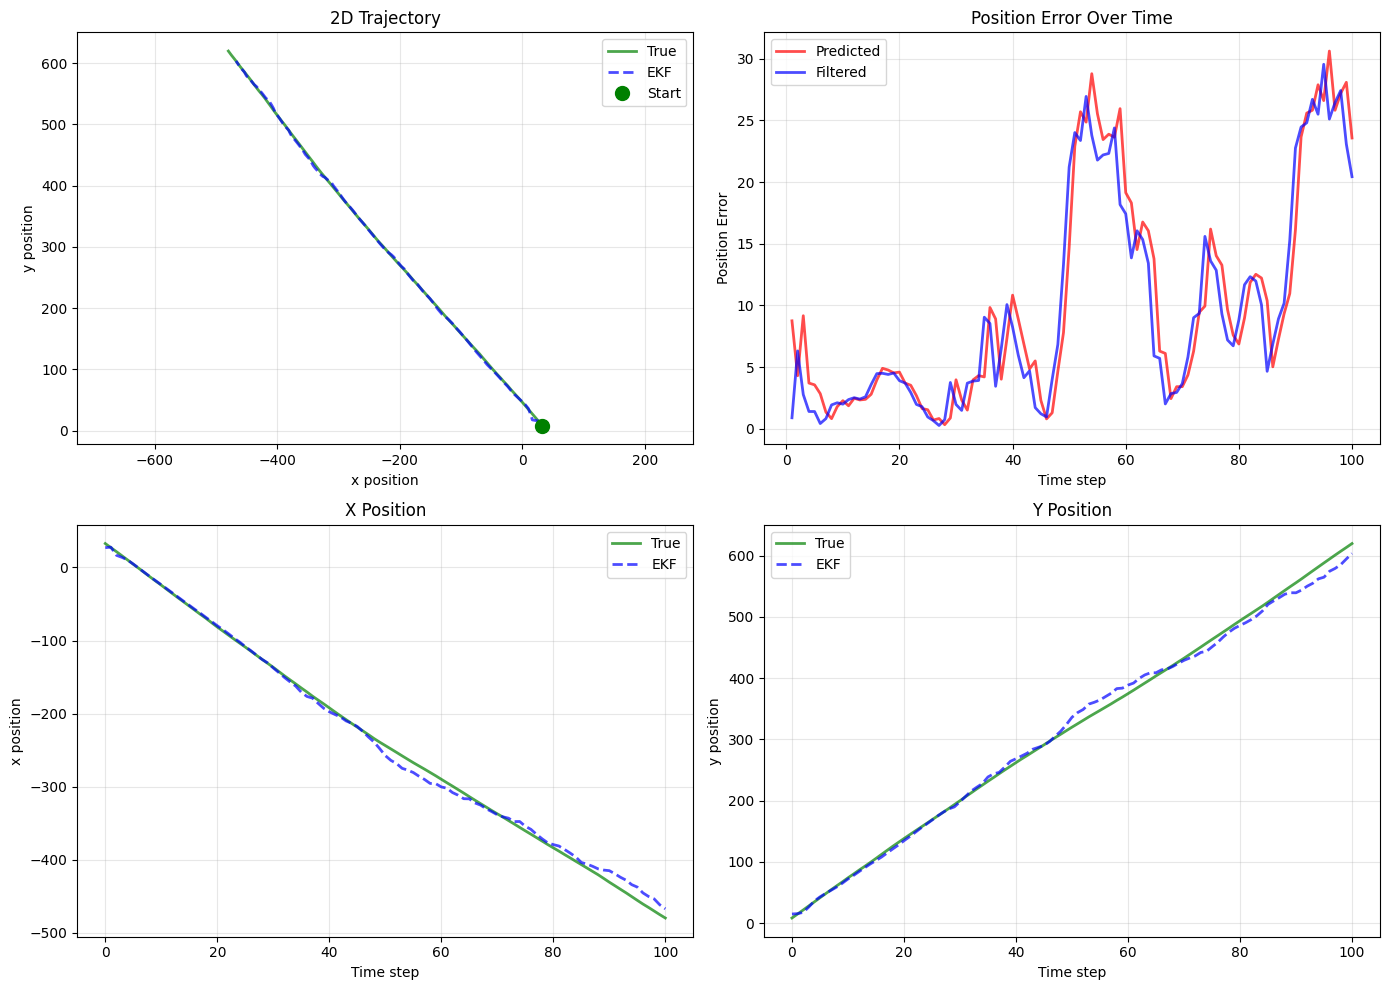

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 2D Trajectory
ax = axes[0, 0]
ax.plot(true_states[0, :].numpy(), true_states[2, :].numpy(), 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(filtered_states[0, :].numpy(), filtered_states[2, :].numpy(), 'b--', linewidth=2, label='EKF', alpha=0.7)
ax.plot(true_states[0, 0].numpy(), true_states[2, 0].numpy(), 'go', markersize=10, label='Start')
ax.set_xlabel('x position')
ax.set_ylabel('y position')
ax.set_title('2D Trajectory')
ax.grid(True, alpha=0.3)
ax.legend()
ax.axis('equal')

# Position Error
ax = axes[0, 1]
time_steps = np.arange(1, T+1)
ax.plot(time_steps, pos_error_predicted.numpy(), 'r-', linewidth=2, label='Predicted', alpha=0.7)
ax.plot(time_steps, pos_error_filtered.numpy(), 'b-', linewidth=2, label='Filtered', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Position Error')
ax.set_title('Position Error Over Time')
ax.grid(True, alpha=0.3)
ax.legend()

# X Position
ax = axes[1, 0]
state_time = np.arange(0, T+1)
ax.plot(state_time, true_states[0, :].numpy(), 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_states[0, :].numpy(), 'b--', linewidth=2, label='EKF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('x position')
ax.set_title('X Position')
ax.grid(True, alpha=0.3)
ax.legend()

# Y Position
ax = axes[1, 1]
ax.plot(state_time, true_states[2, :].numpy(), 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_states[2, :].numpy(), 'b--', linewidth=2, label='EKF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('y position')
ax.set_title('Y Position')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

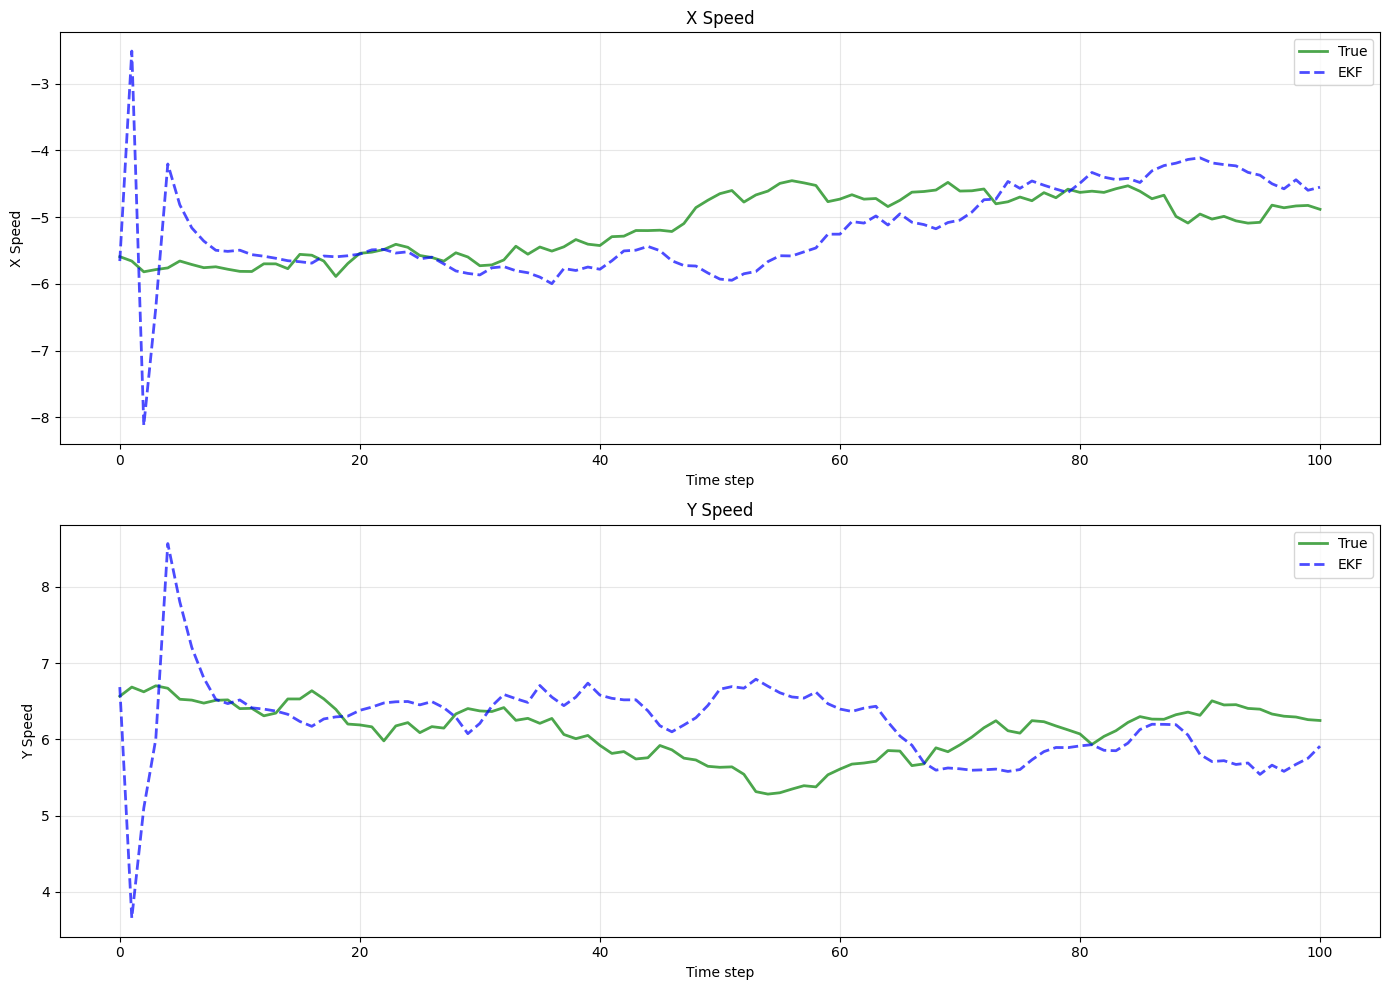

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# X Speed
ax = axes[0]
state_time = np.arange(0, T+1)
ax.plot(state_time, true_states[1, :].numpy(), 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_states[1, :].numpy(), 'b--', linewidth=2, label='EKF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('X Speed')
ax.set_title('X Speed')
ax.grid(True, alpha=0.3)
ax.legend()

# Y Position
ax = axes[1]
ax.plot(state_time, true_states[3, :].numpy(), 'g-', linewidth=2, label='True', alpha=0.7)
ax.plot(state_time, filtered_states[3, :].numpy(), 'b--', linewidth=2, label='EKF', alpha=0.7)
ax.set_xlabel('Time step')
ax.set_ylabel('Y Speed')
ax.set_title('Y Speed')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()